In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d


%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Chandra files

In [9]:
w, b, f, e1, e2 = np.loadtxt('Chandra/GJ699all_spectrum.dat', skiprows=3, unpack=True)

<ErrorbarContainer object of 3 artists>

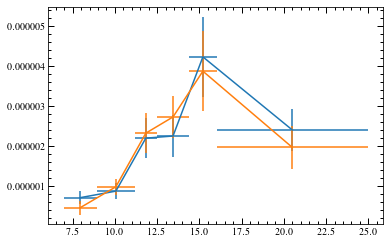

In [13]:
plt.errorbar(w, f, xerr=b, yerr=e1)
plt.errorbar(w, e2, xerr=b, yerr=e1)

In [14]:
w, b, f, e1, e2 = np.loadtxt('Chandra/GJ699quiet_spectrum.dat', skiprows=3, unpack=True)

<ErrorbarContainer object of 3 artists>

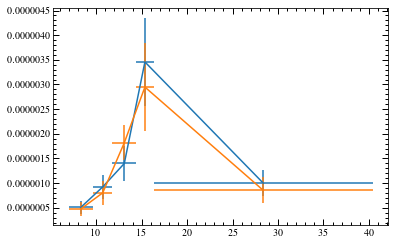

In [15]:
plt.errorbar(w, f, xerr=b, yerr=e1)
plt.errorbar(w, e2, xerr=b, yerr=e1)

In [16]:
lya = Table.read('lya/GJ699_G140M_intrinsic_lya_profile.txt', format='ascii')

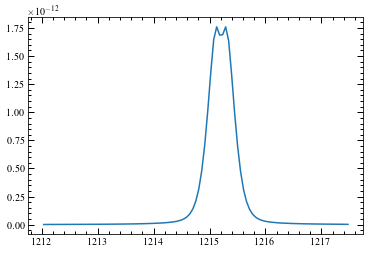

In [18]:
plt.plot(lya['wave'], lya['intrinsic_lya'])

In [20]:
savedat= Table([lya['wave'], lya['intrinsic_lya']], names=['WAVELENGTH', 'FLUX'])
savedat.write('lya/GJ699_lya_simple.txt', format='ascii')

In [21]:
mw, mb, mf = np.loadtxt('Chandra/GJ699all_model.dat', skiprows=3, unpack=True)

<ErrorbarContainer object of 3 artists>

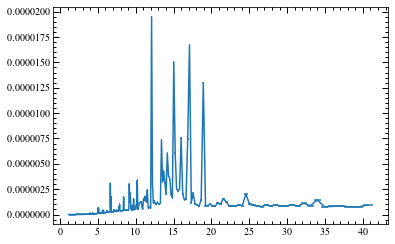

In [22]:
plt.errorbar(mw, mf, xerr=mb)

In [23]:
chandra_path = '/home/david/work/muscles/MegaMUSCLES/GJ_699/Chandra/primary/'

In [24]:
cfiles = os.listdir(chandra_path)
cfiles

['acisf20619_000N001_fov1.fits.gz',
 'acisf20619N001_cntr_img2.jpg.gz',
 'acisf20619N001_cntr_img2.fits.gz',
 'acisf20619_000N001_bpix1.fits.gz',
 'pcadf677149624N001_asol1.fits.gz',
 'orbitf677073905N001_eph1.fits.gz',
 'acisf20619N001_full_img2.jpg.gz',
 'acisf20619N001_evt2.fits.gz',
 'acisf20619N001_full_img2.fits.gz']

In [25]:
evts = fits.open(chandra_path+'acisf20619N001_evt2.fits.gz')

In [26]:
evts.info()

Filename: /home/david/work/muscles/MegaMUSCLES/GJ_699/Chandra/primary/acisf20619N001_evt2.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      30   ()      
  1  EVENTS        1 BinTableHDU    838   32749R x 19C   [1D, 1I, 1I, 1J, 1I, 1I, 1I, 1I, 1E, 1E, 1E, 1E, 1J, 1J, 1E, 1J, 1I, 1I, 32X]   
  2  GTI           7 BinTableHDU     28   1R x 2C   [1D, 1D]   


In [27]:
evts[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
HDUNAME = 'PRIMARY '                                                            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'ASC     '           / Source of FITS file                            
CREATOR = 'cxc - Version DS10.7' / tool that created this output                
CHECKSUM= 'UmiBajiAVjiAajiA'   / HDU checksum updated 2019-06-17T22:22:12       
DATASUM = '        '        

In [29]:
from astropy.time import Time

In [30]:
hdr = evts[0].header

In [31]:
hdr['TSTOP'] -hdr['TSTART']

30385.61431992054

In [36]:
times = Time([hdr['DATE-OBS'], hdr['DATE-END']])
times

<Time object: scale='utc' format='isot' value=['2019-06-17T08:52:14.000' '2019-06-17T17:18:39.000']>

In [40]:
np.diff(times)[0].to(u.s)

<Quantity 30385. s>

In [47]:
tstart = Time(hdr['DATE-OBS'])
tend = Time(hdr['DATE-END'])
exptime = (tend-tstart).to(u.s)
print(tstart, tend, exptime)


2019-06-17T08:52:14.000 2019-06-17T17:18:39.000 30385.000000000004 s


In [49]:
w, b, f, e1, e2 = np.loadtxt('Chandra/all/GJ699all_spectrum.dat', skiprows=3, unpack=True)

<ErrorbarContainer object of 3 artists>

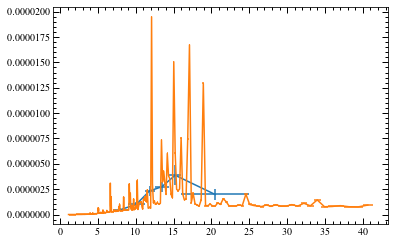

In [52]:
#plt.errorbar(w, f, xerr=b, yerr=e1)
plt.errorbar(w, e2, xerr=b, yerr=e1)
plt.errorbar(mw, mf, xerr=mb)

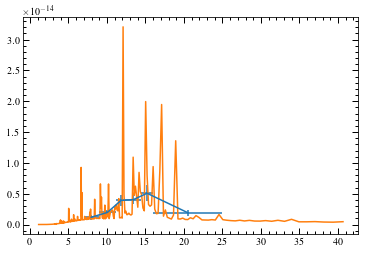

In [58]:
fn = [fi*1.99e-8/wi for fi, wi in zip(e2,w)]
en = (e1/e2)*fn
plt.errorbar(w, fn, xerr=b, yerr=en)

mfn = [fi*1.99e-8/wi for fi, wi in zip(mf,mw)]
plt.plot(mw, mfn)


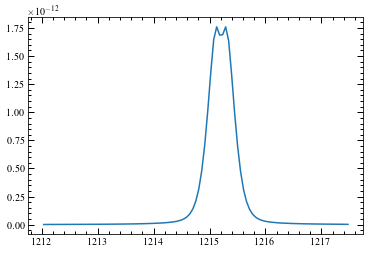

In [59]:
plt.plot(lya['wave'], lya['intrinsic_lya'])

In [60]:
wl, fl = lya['wave'], lya['intrinsic_lya']


In [61]:
mask = (wl > 1214) & (wl < 1217)
np.trapz(fl[mask], wl[mask])

1.039869917054704e-12

In [62]:
np.trapz(fl, wl)

1.0500816791979071e-12

In [3]:
#evts[1].header

In [5]:
#evts[2].header

20190911 looking at the compleated SED, something up with the scaling.

In [7]:
sed_v1 = Table.read('../common/quicksaves/GJ699_basic.ecsv')

/home/david/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


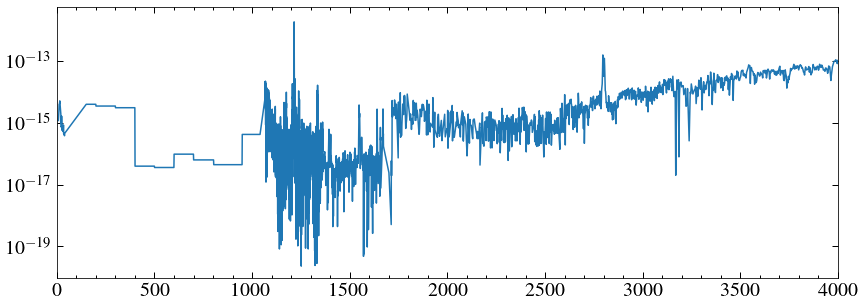

In [12]:
plt.plot(sed_v1['WAVELENGTH'][sed_v1['FLUX'] >0], sed_v1['FLUX'][sed_v1['FLUX'] >0])
plt.xlim(0, 4000)
#plt.ylim(-1e-14, 1e-13)
plt.yscale('log')

Think about that later. First, dems...

In [14]:
dems = glob.glob('dem/*dem*')
dems

['dem/gj699_flare_dem_spectrum.fits', 'dem/gj699_quiet_dem_spectrum.fits']

In [16]:
hdul =fits.open(dems[0])

In [19]:
hdul[1].data.names

['Wavelength', 'Flux_density', 'Lower_Error_16', 'Upper_Error_84']

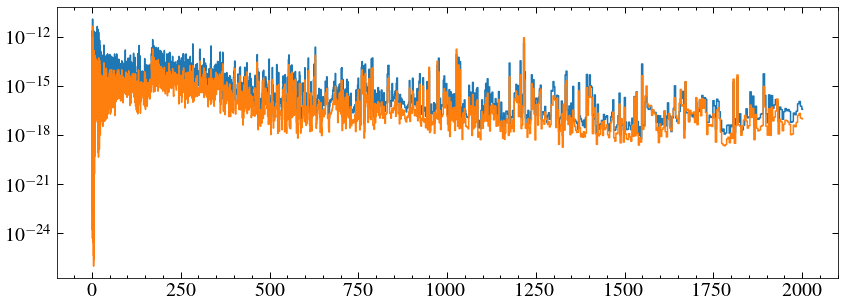

In [36]:
for d in dems:
    dt = fits.getdata(d, 1)
    plt.step(dt['Wavelength'][dt['Flux_density'] >0], dt['Flux_density'][dt['Flux_density'] >0], where='mid')
    if d == 'dem/gj699_flare_dem_spectrum.fits':
        wf, ff = dt['Wavelength'], dt['Flux_density']
    else:
        wq, fq = dt['Wavelength'], dt['Flux_density']
    plt.yscale('log')

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


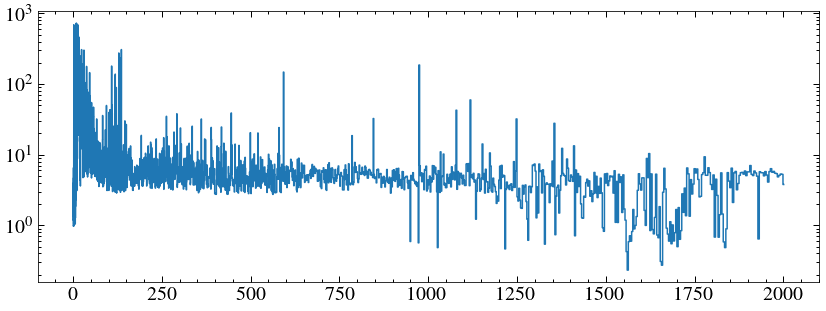

In [37]:
plt.step(wf, ff/fq, where='mid')
plt.yscale('log')

In [38]:
np.median(ff/fq)

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/david/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


nan

Ok so we do need to treat them separatly

In [31]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  

In [39]:
mean_flux = 0.75*fq +0.25*ff

(40, 100)

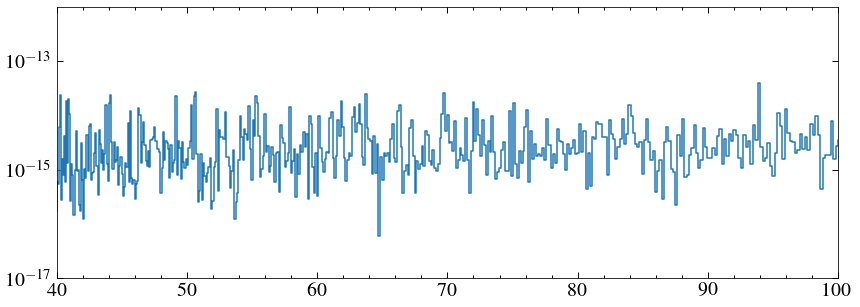

In [54]:
#for d in dems:
#    dt = fits.getdata(d, 1)
 #   plt.step(dt['Wavelength'][dt['Flux_density'] >0], dt['Flux_density'][dt['Flux_density'] >0], where='mid')
plt.step(wf, mean_flux, where='mid')
plt.yscale('log')
plt.ylim(1e-17, 1e-12)
plt.xlim(40, 100)

In [41]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                 3805 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'Wavelength'                                                          
TFORM1  = 'D       '                                                            
TUNIT1  = 'Angstrom'                                                            
TTYPE2  = 'Flux_density'                                                        
TFORM2  = 'D       '        

In [42]:
def wavelength_edges(w):
    """
    Calulates w0 and w1
    """
    diff = np.diff(w)
    diff = np.concatenate((np.array([diff[0]]), diff)) #adds an extravalue to make len(diff) = len(w)
    w0 = w - diff/2.
    w1 = w + diff/2.
    return w0, w1
x
def dem_to_1A(w,f):
    """
    Converts a DEM model at 5A resolution to 1A resolution
    """
    w1 = np.arange(w[0], w[-1], 1.)
    f1 = interp1d(w, f, fill_value='extrapolate', kind='nearest')(w1)
    return w1, f1, 

In [59]:
wavelength, bin_flux = wf, mean_flux

w0, w1 = wavelength_edges(wavelength)
flux = bin_flux/(w1-w0) #convert from bin-intergrated flux to flux 
#name = 'dem.txt' 
#save_path='euv_repo/'
#savedat = Table([wavelength, flux], names=['WAVELENGTH', 'FLUX'])
#ascii.write(savedat, save_path+name, overwrite=True)

In [60]:
wavelength, bin_flux = wf, mean_flux
fitsdat =  Table([wavelength, bin_flux], names=['WAVELENGTH', 'Bin-Integrated Flux'])
hdr = fits.Header()
primary_hdu = fits.PrimaryHDU(header=hdr)
hdu = fits.table_to_hdu(fitsdat)
hdul = fits.HDUList([primary_hdu, hdu])
hdul.writeto('dem/gj699_time_average_dem.fits', overwrite=True)

In [46]:
hdul.close()
hdul=fits.open('dem/gj699_time_average_dem.fits')
hdul.info()

Filename: dem/gj699_time_average_dem.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     12   3805R x 2C   [D, D]   


In [47]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                 3805 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'WAVELENGTH'                                                          
TFORM1  = 'D       '                                                            
TTYPE2  = 'Bin-Integrated_FlUX'                                                 
TFORM2  = 'D       '                                                            

Looks like we need an averaged Chandra spectrum as well- nope we already have it.

In [61]:
dem1 = Table.read('test_files/components/hlsp_muscles_model_dem_gj699_na_v1_component-spec.ecsv')

(0, 1000)

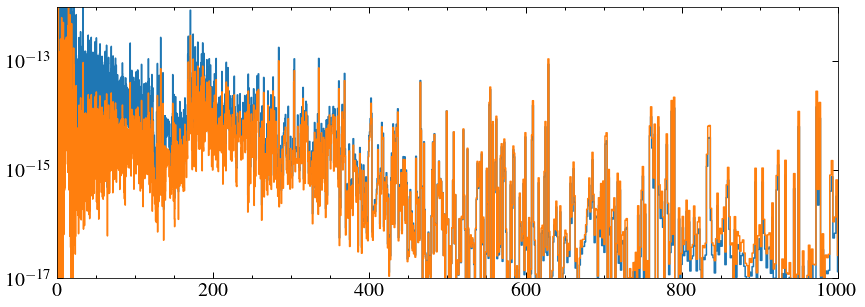

In [68]:
plt.step(dem1['WAVELENGTH'], dem1['FLUX'], where='mid')
plt.step(wf, mean_flux, where='mid')
plt.yscale('log')
plt.ylim(1e-17, 1e-12)
plt.xlim(0, 1000)

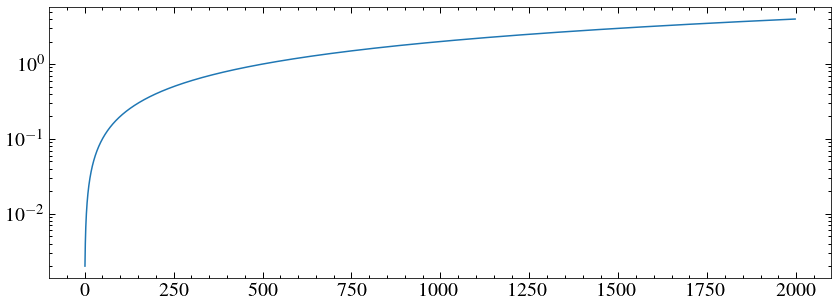

In [64]:
plt.plot(wf[:-1],np.diff(wf))
plt.yscale('log')

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


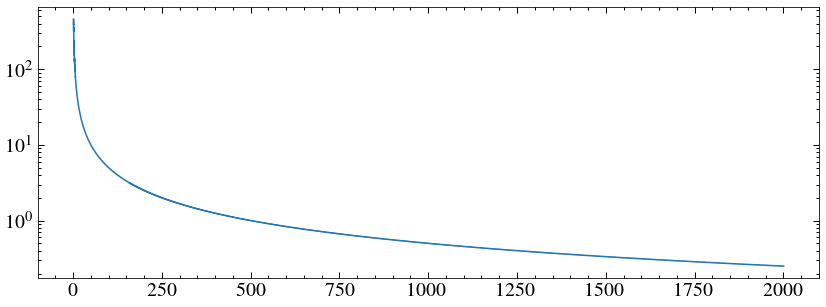

In [67]:
plt.step(dem1['WAVELENGTH'], dem1['FLUX']/mean_flux, where='mid')
plt.yscale('log')